### Introduction

This a notebook contains our final project code for the course 02456 Deep learning from DTU. We have collaborated with the company Beep Analytics who makes analytics solutions for the airplane supply chain industry.

The goal of this project is to create a multi-label classifier with deep learning that can identify which airplane parts fits to different airplane models. The raw data comes from the 
Federal Aviation Administration PMA parts database that is publicly avialable at https://www.faa.gov/aircraft/air_cert/design_approvals/pma/pma_parts/. Beep Analytics has labeled the training data and made it available for us, but it is not available publicly. 

### Method
The project is a NLP project. Our X-features are strings that contains one or multiple airplane models. From this string we want to classify the airplane models that are contained in that string since this is currently not in a format that can be filtered with a machine. We have tried different approaches to solve this problem. We have tried a pretrained model like ALBERT, but the best result we got was with a bidirectional LSTM model. 

The rest of the notebook will explain how we went though the task. The data was been oversampled and splitted into train, validation and test data in another notebook in this repository. 


In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn import metrics

# Pytorch imports 
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchtext import data
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [7]:
# Preprocessing imports
import re  
import ast

# Function for cleaning up the text strings on import. 
def cleanup_text(texts):
    cleaned_text = []
    for text in texts:
        # remove punctuation
        text = re.sub('[^a-zA-Z0-9]', ' ', text)
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)
        # remove newline
        text = re.sub(r'\n', ' ', text)
        text = text.rstrip()
        cleaned_text.append(text)
    return cleaned_text

# Function for converting a list from a string to list object
def list_literal_evel(labels):
    return ast.literal_eval(labels)

In [8]:
# Tokenizer + lower case strings
tokenizer = lambda s: s.lower().split()
    
# Fiels: Text is our features, Label is our targets
Text = data.Field(preprocessing=cleanup_text, tokenize=tokenizer, batch_first=True, include_lengths=True) 
Label = data.Field(preprocessing=list_literal_evel, sequential=False, use_vocab=False, pad_token=None, unk_token=None)

In [9]:
fields = [('Models', Text), ('labels', Label)]

In [10]:
# Loads the training, validation and test data.
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=r"C:\Users\DeepLearning2020\notebooks",
    train='train_data_020121.csv',
    validation='valid_data_020121.csv',
    test='test_data_020121.csv',
    format='csv',
    fields=fields,
    skip_header=True
)

In [12]:
#At look at training example
print(vars(train_data[100]))

{'Models': ['harbin', ' y12iv'], 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
# Creates vocab
from torchtext import vocab
Text.build_vocab(train_data, max_size=5000)
Label.build_vocab(train_data)

In [14]:
# Model paramenters:
learning_rate = 1e-3 
batch_size = 64
dropout = 0.5
embedding_size = 300
seed = 1
num_classes = 462
num_epochs = 10
hidden_size = 200
input_size = 200
vocab_size = len(Text.vocab)

In [15]:
class LSTM(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, dropout, num_classes):
        super().__init__()
        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dimension = hidden_size

        # Bi-LSTM
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=hidden_size,
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        # Dropout
        self.drop = nn.Dropout(p=dropout)

        # Output layer
        self.fc1 = nn.Linear(2*hidden_size, 2*hidden_size)
        self.fc2 = nn.Linear(2*hidden_size, num_classes)
        self.batch1 = nn.BatchNorm1d(2*hidden_size)

    def forward(self, text, text_len):
        # Embedding
        text_len = text_len.cpu().long()
        text_emb = self.embedding(text)

        # LSTM input
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # LSTM Output
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)

        # Dropout
        X = self.drop(out_reduced)

        # Output Layer
        X = self.fc1(X)
        X = torch.squeeze(X, 1)
        X = F.elu(X)
        X = self.drop(out_reduced)
        X = self.batch1(X)
        X = self.fc2(X)
        X = torch.sigmoid(X)

        return X

In [16]:
# Function to create pytorch iterators
def create_iterator(train_data, valid_data, test_data, batch_size, device):    
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data),
        batch_size = batch_size,
        sort_key = lambda x: len(x.Models), 
        sort_within_batch = True,
        device = device)
        
    return train_iterator, valid_iterator, test_iterator

In [17]:
from sklearn.metrics import accuracy_score

# Accuracy function
def accuracy(y_pred, y_true):
    accuracy = ((y_pred>0.5).float() == y_true).sum()
    n = y_pred.shape[0]*y_pred.shape[1]
    return (accuracy.item()/n)


In [18]:
# Function for training
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.Models
        predictions = model(text, text_lengths)
        loss = criterion(predictions, batch.labels.float())
        acc = accuracy(predictions, batch.labels) 
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
# Function for evaluation
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.Models
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.labels.float())
            acc = accuracy(predictions, batch.labels)
            epoch_loss += loss.item()
            epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
# Creates iterators
train_iterator, valid_iterator, test_iterator = create_iterator(train_data, valid_data, test_data, batch_size, device)

c:\Miniconda\envs\py37_pytorch\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [21]:
# Creates to model, loss and optimizer
model = LSTM(vocab_size, embedding_size, hidden_size, dropout, num_classes).to(device)
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.2, nesterov=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [22]:
# List for evaluation metrics
train_acc_l, train_loss_l = [], []
valid_acc_l, valid_loss_l = [], []

In [23]:
# Training 
for epoch in range(num_epochs):

    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_loss_l.append(train_loss)
    train_acc_l.append(train_acc)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_loss_l.append(valid_loss)
    valid_acc_l.append(valid_acc)

    print(f'\tEpoch: {epoch} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\tEpoch: {epoch} | Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

c:\Miniconda\envs\py37_pytorch\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


	Epoch: 0 | Train Loss: 0.023 | Train Acc: 99.19%
	Epoch: 0 | Val. Loss: 0.024 |  Val. Acc: 99.19%
	Epoch: 1 | Train Loss: 0.005 | Train Acc: 99.83%
	Epoch: 1 | Val. Loss: 0.020 |  Val. Acc: 99.35%
	Epoch: 2 | Train Loss: 0.004 | Train Acc: 99.86%
	Epoch: 2 | Val. Loss: 0.020 |  Val. Acc: 99.36%
	Epoch: 3 | Train Loss: 0.003 | Train Acc: 99.87%
	Epoch: 3 | Val. Loss: 0.016 |  Val. Acc: 99.45%
	Epoch: 4 | Train Loss: 0.003 | Train Acc: 99.88%
	Epoch: 4 | Val. Loss: 0.017 |  Val. Acc: 99.44%
	Epoch: 5 | Train Loss: 0.003 | Train Acc: 99.89%
	Epoch: 5 | Val. Loss: 0.018 |  Val. Acc: 99.44%
	Epoch: 6 | Train Loss: 0.003 | Train Acc: 99.89%
	Epoch: 6 | Val. Loss: 0.015 |  Val. Acc: 99.49%
	Epoch: 7 | Train Loss: 0.003 | Train Acc: 99.90%
	Epoch: 7 | Val. Loss: 0.015 |  Val. Acc: 99.51%
	Epoch: 8 | Train Loss: 0.003 | Train Acc: 99.90%
	Epoch: 8 | Val. Loss: 0.016 |  Val. Acc: 99.51%
	Epoch: 9 | Train Loss: 0.002 | Train Acc: 99.90%
	Epoch: 9 | Val. Loss: 0.015 |  Val. Acc: 99.53%


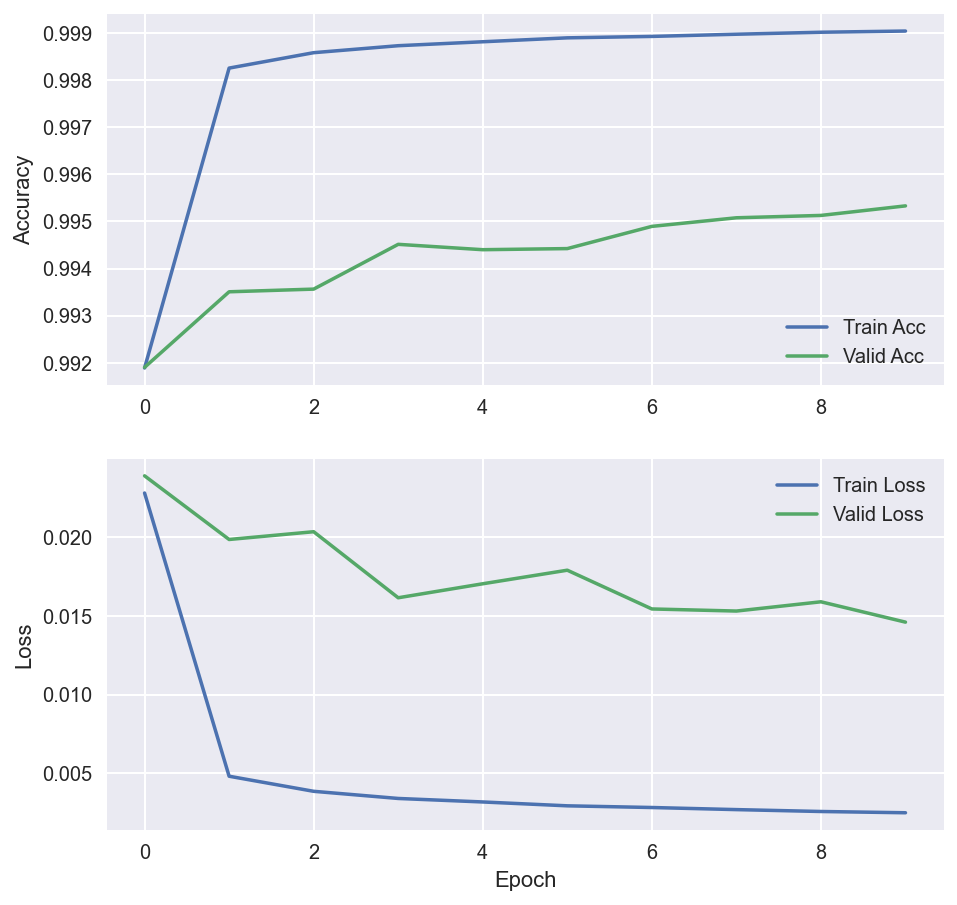

In [79]:
# Plots training curves
fig, ax = plt.subplots(2)
fig.set_size_inches(7.5, 7.5)
ax[0].plot(np.arange(len(train_acc_l)), train_acc_l, label='Train Acc')
ax[0].plot(np.arange(len(valid_acc_l)), valid_acc_l, label='Valid Acc')
ax[0].legend()
ax[0].set_ylabel('Accuracy')
ax[1].plot(np.arange(len(train_acc_l)), train_loss_l, label='Train Loss')
ax[1].plot(np.arange(len(valid_acc_l)), valid_loss_l, label='Valid Loss')
ax[1].legend()
ax[1].set_ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('acc_loss.png', dpi=200)
plt.show()

In [26]:
# Evaluates the model on the test data
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'The test loss is: {round(test_loss, 4)}')
print(f'The test acc is: {round(test_acc, 4)}')

c:\Miniconda\envs\py37_pytorch\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


The test loss is: 0.013
The test acc is: 0.9956


In [80]:
# Saves the model
torch.save(model.state_dict(), 'final_model_020121')

In [28]:
# Get predictions for the test data
y_true = []
y_pred = []

model.eval()

for batch in test_iterator:
    text, text_lengths = batch.Models
    predictions = model(text, text_lengths)
    y_true.append(batch.labels.cpu().numpy())
    y_pred.append((predictions>0.5).cpu().numpy())

In [29]:
from sklearn.metrics import classification_report

In [81]:
# Global evaluation metrics
print(classification_report(np.concatenate(y_true, axis=0).flatten(), np.concatenate(y_pred, axis=0).astype(int).flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3571112
           1       0.90      0.79      0.84     52354

    accuracy                           1.00   3623466
   macro avg       0.95      0.89      0.92   3623466
weighted avg       1.00      1.00      1.00   3623466



In [83]:
# Per class evaluation metrics
report = classification_report(np.concatenate(y_true, axis=0), np.concatenate(y_pred, axis=0).astype(int), output_dict=True)

In [88]:
# Create dataframe with the metrics
import pandas as pd
report_df = pd.DataFrame(report)
report_df = report_df.T[:462]

In [89]:
report_df

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.0
3,1.000000,1.000000,1.000000,2.0
4,0.978261,0.918367,0.947368,147.0
...,...,...,...,...
457,0.000000,0.000000,0.000000,0.0
458,0.965116,0.790476,0.869110,105.0
459,0.000000,0.000000,0.000000,0.0
460,0.000000,0.000000,0.000000,0.0


In [91]:
# Scales the support between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
report_df['Support'] = scaler.fit_transform(report_df['support'].values.reshape(-1, 1))

In [92]:
# Selects all predicts with a support higher than 0. Thus is due to that not all classes are contained in the test set.
report_df = report_df[report_df['Support'] > 0]

In [94]:
report_df.rename(columns={'precision': 'Precision', 'recall': 'Recall'}, inplace=True)

c:\Miniconda\envs\py37_pytorch\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



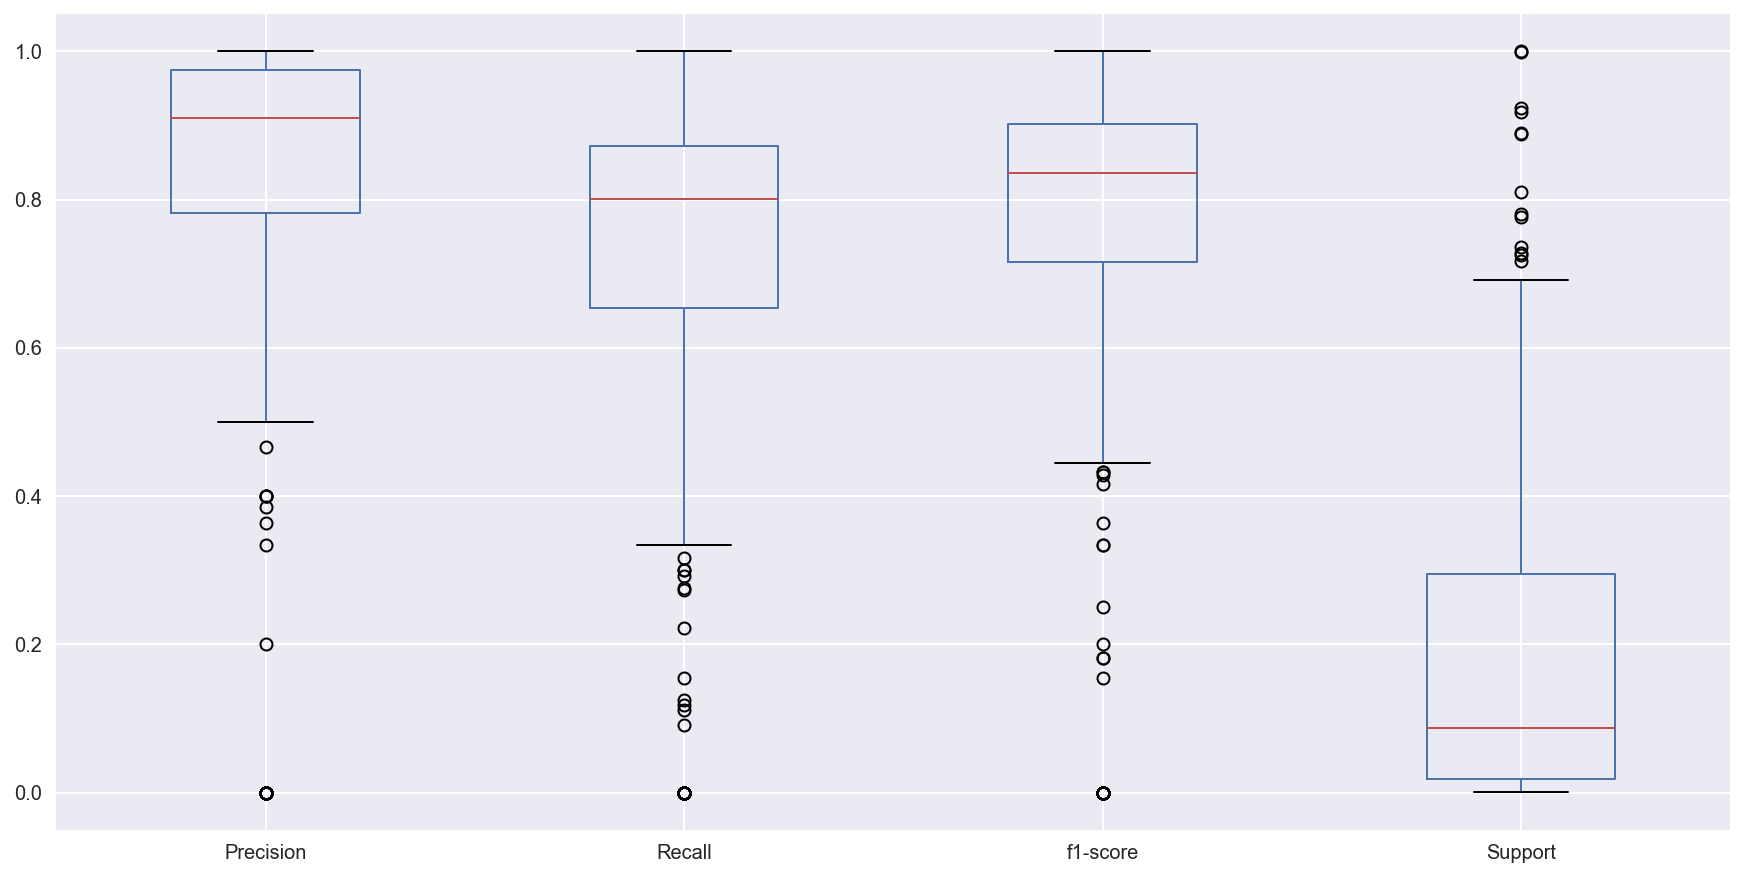

In [95]:
# Plots boxplots of each evaluation metric
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
report_df.boxplot(column=['Precision', 'Recall', 'f1-score','Support'])
plt.savefig('boxplot.png', dpi=200)
plt.show()

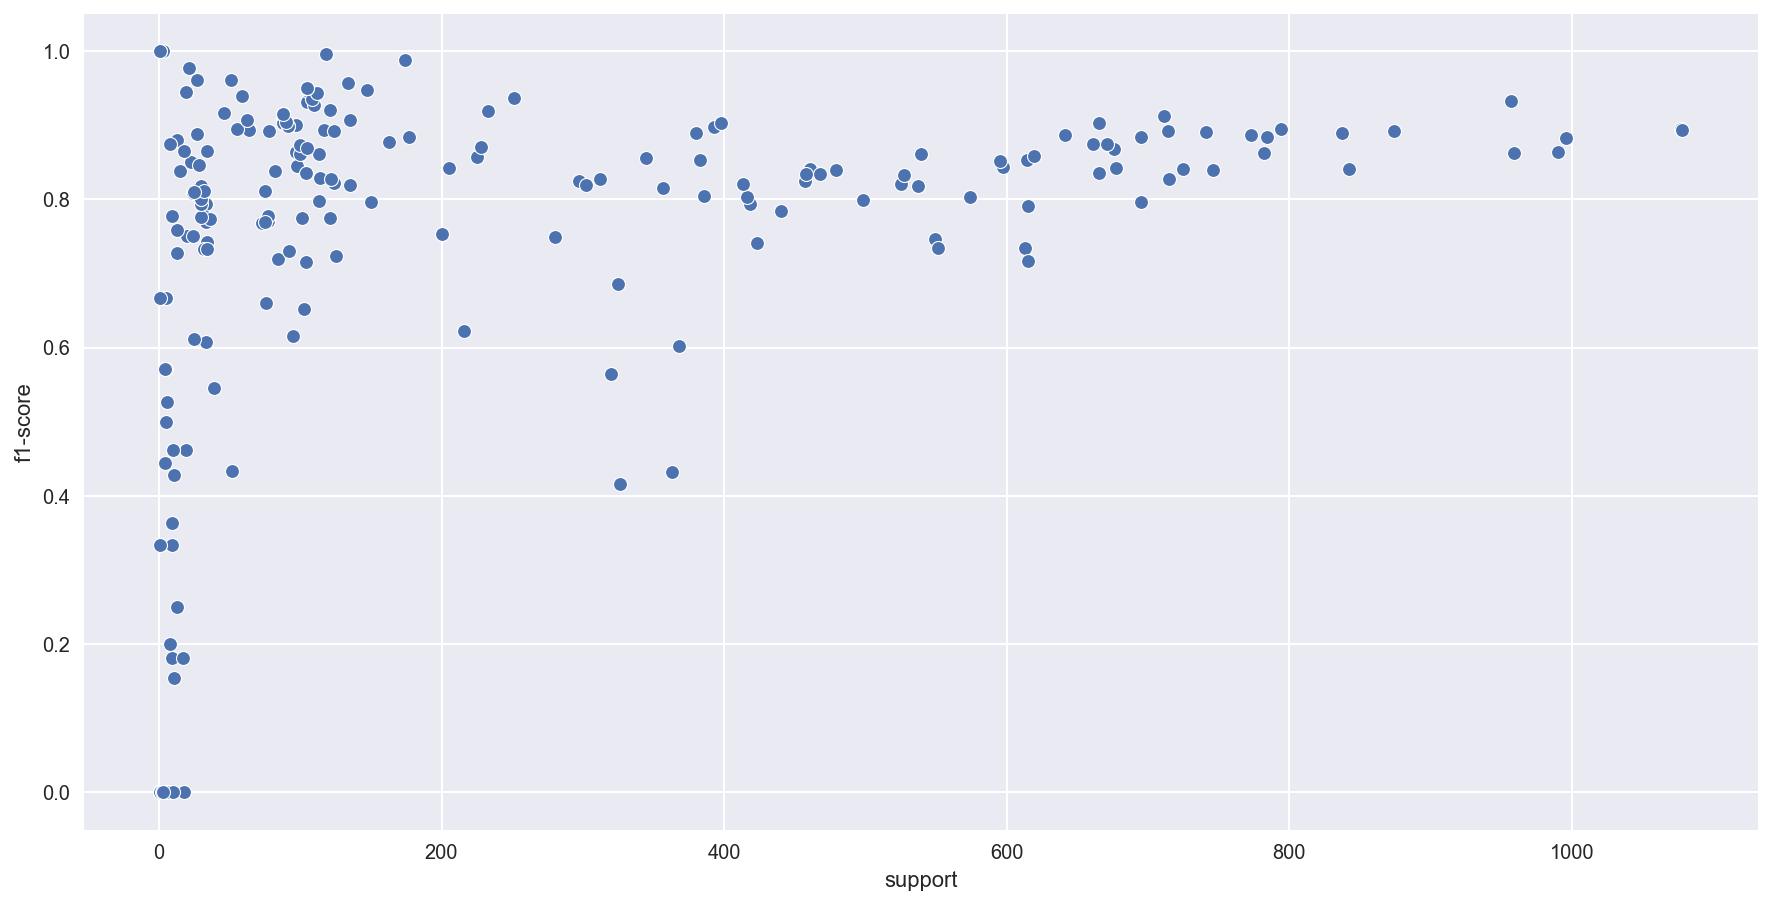

In [102]:
# Plots the support vs the f1-score
plt.figure(figsize=(15,7.5))
sns.scatterplot(x = report_df["support"], y=report_df['f1-score'])
plt.show()